<a href="https://colab.research.google.com/github/andrecoimbra/CTG_RP_PC_2025/blob/main/CTG_Generate_Recurrence_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTG Generate Recurrence Plots

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! wget https://raw.githubusercontent.com/andrecoimbra/CTG_RP_PC_2025/main/src/config_local.py

--2024-07-06 01:50:44--  https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/config_local.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1425 (1.4K) [text/plain]
Saving to: ‘config_local.py’

config_local.py     100%[===================>]   1.39K  --.-KB/s    in 0s      

2024-07-06 01:50:45 (27.7 MB/s) - ‘config_local.py’ saved [1425/1425]



In [ ]:
from config_local import *
get_github_files(['ctg_utils.py', 'basic_denoise.py', 'libRP.py' ])    # for development purposes only

Beginning file download of file ctg_utils.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/ctg_utils.py
Beginning file download of file basic_denoise.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/basic_denoise.py
Beginning file download of file libRP.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/libRP.py
Done


In [ ]:
#! rm -R  /content/images
! ls  /content

basic_denoise.py  config_local.py  ctg_utils.py  libRP.py  __pycache__	sample_data


In [ ]:
! pip install wfdb
! pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00


In [ ]:
import os
import json
from pprint import pprint

import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

import wfdb
from ctg_utils import get_all_recno, parse_meta_comments
import basic_denoise
from basic_denoise import get_valid_segments

from libRP import create_rp

In [ ]:
!wget -r -N -c -np -q --show-progress -P /content/ctu-uhb-ctgdb https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

physionet.org/files     [  <=>               ] 122.50K   293KB/s    in 0.4s    
physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      
physionet.org/files 100%[===================>]  75.00K   274KB/s    in 0.3s    
physionet.org/files 100%[===================>]     926  --.-KB/s    in 0s      
physionet.org/files 100%[===================>]  75.00K   276KB/s    in 0.3s    
physionet.org/files 100%[===================>]     922  --.-KB/s    in 0s      
physionet.org/files 100%[===================>]  70.31K   260KB/s    in 0.3s    
physionet.org/files 100%[===================>]     924  --.-KB/s    in 0s      
physionet.org/files 100%[===================>]  65.62K   353KB/s    in 0.2s    
physionet.org/files 100%[===================>]     926  --.-KB/s    in 0s      
physionet.org/files 100%[===================>]  70.31K   370KB/s    in 0.2s    
physionet.org/files 100%[===================>]     921  --.-KB/s    in 0s      
physionet.org/files 100%[===============

In [ ]:
!mv /content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/* /content/ctu-uhb-ctgdb
!rm -r /content/ctu-uhb-ctgdb/physionet.org

# Config

In [ ]:
POLICY='early_valid' # 'best_quality', 'early_valid', 'late_valid'

# Code

In [ ]:
def generate_rp_images(recordings_dir, n_dec=4, clip_stage_II=True,
                       max_seg_min=10, policy='early_valid',
                       rp_params=[{}],
                       images_dir='',
                       images_index_file='rp_images_index.json',
                       show_signal=False, show_image=False, verbose=False, cmap=None,
                       limit=-1):

    assert policy in ['best_quality', 'early_valid', 'late_valid']

    if images_dir and not os.path.exists(images_dir):
        os.mkdir(images_dir)

    max_seg = int(max_seg_min*60*4)  # convert to samples

    results = {}
    for recno in sorted(get_all_recno(recordings_dir)):
        limit -= 1
        if limit == 0:
            break

        recno_full = os.path.join(recordings_dir, recno)
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta = parse_meta_comments(meta['comments'])
        if verbose:
            print('\nRecord: {}  Samples: {}   Duration: {:0.1f} min   Stage.II: {} min'.format(
                recno, all_sig.shape[0], all_sig.shape[0]/4/60, meta['Delivery']['II.stage']))

        sig_hr = all_sig[:, 0]
        if clip_stage_II and meta['Delivery']['II.stage'] != -1:
            idx = int(meta['Delivery']['II.stage']*60*4)
            sig_hr = sig_hr[:-idx]
        ts = np.arange(len(sig_hr))/4.0

        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Signal'.format(recno))
            plt.plot(ts/60, sig_hr)
            plt.xlim(ts[0], ts[-1]/60)
            plt.ylim(50, 200)
            plt.show()

        # select segment with lowest error rate
        selected_segments = get_valid_segments(sig_hr, ts, recno, verbose=False)

        if len(selected_segments) == 0:
            continue

        if policy == 'best_quality':
            selected_segments = sorted(selected_segments, key=lambda x: -x['pct_valid'])
        elif policy == 'early_valid':
            selected_segments = sorted(selected_segments, key=lambda x: x['seg_start'])
        elif policy == 'late_valid':
            selected_segments = sorted(selected_segments, key=lambda x: -x['seg_end'])

        seg =  selected_segments[0]
        seg_start = seg['seg_start']
        seg_end = seg['seg_end']
        seg_hr = seg['seg_hr']
        seg_tm = seg['seg_ts'] / 60
        orig_seg_hr = seg['orig_seg_hr']
        mask = seg['mask']
        pct_valid = seg['pct_valid']

        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Segment  {}-{}'.format(recno, seg_start, seg_end))
            plt.plot(seg_tm, seg_hr)
            plt.plot(seg_tm, orig_seg_hr, alpha=0.25)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(50, 200)
            plt.show()

            plt.figure(figsize=(12, 0.75))
            plt.title('{}: Invalid'.format(recno))
            plt.plot(seg_tm, ~mask)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(-0.1, 1.1)
            plt.show()

            print('Valid: {:0.1f}%'.format(100 * pct_valid))

        if policy == 'late_valid':
            selected_hr = seg_hr[-max_seg:]
        else:
            selected_hr = seg_hr[:max_seg]

        if n_dec > 1:
            selected_hr = scipy.signal.decimate(selected_hr,n_dec)

        image_names = []
        for p in rp_params:
                fname = create_rp(selected_hr, base_name=recno, show_image=show_image,
                                  images_dir=images_dir, cmap=cmap, **p)
                image_names.append(fname)

        results[recno] = {'names':image_names, 'outcome':meta['Outcome']}

#     if verbose:
#         pprint(results)

    with open(os.path.join(images_dir, images_index_file), 'w') as outfile:
        json.dump(results, outfile)

## Process Recordings

In [ ]:
# Configure Recurrent Plot Parameters

rp_params = []

for dimension in [2]:
    for time_delay in [1]:
        for percentage in [1,3, 10]:
            for use_clip in [False]: # [False, True]:
                rp_params.append({'dimension':dimension, 'time_delay':time_delay,
                                  'percentage':percentage, 'use_clip':use_clip})


rp_params

[{'dimension': 2, 'percentage': 1, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 3, 'time_delay': 1, 'use_clip': False},
 {'dimension': 2, 'percentage': 10, 'time_delay': 1, 'use_clip': False}]


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


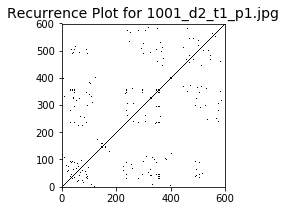


Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min


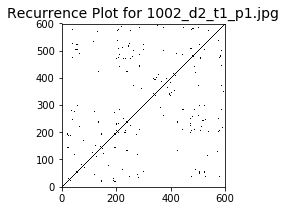

In [ ]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params[:1],
                   policy=POLICY,
                   show_signal=False, show_image=True, verbose=True, cmap='binary',
                   limit=3,
                  )

In [ ]:
generate_rp_images(RECORDINGS_DIR, images_dir=IMAGES_DIR, rp_params=rp_params,
                   policy='early_valid', # 'best_quality', 'early_valid', 'late_valid'
                   show_signal=False, show_image=False, verbose=True, cmap='binary',
#                    limit=3,
                  )


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1003  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1004  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1005  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1006  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1007  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1008  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1009  Samples: 20400   Duration: 85.0 min   Stage.II: 25 min

Record: 1010  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1011  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1012  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1013  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1014  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1015  Samples

In [ ]:
IMAGES_DIR

'/content/images'

In [ ]:
ls /content/images/1171*

/content/images/1171_d2_t1_p10.jpg  /content/images/1171_d2_t1_p3.jpg
/content/images/1171_d2_t1_p1.jpg


In [ ]:
with open(os.path.join(IMAGES_DIR, 'rp_images_index.json'), 'r') as infile:
        data = json.load(infile)

print('Recordings:', len(data.keys()))
print('Sample Recording :', data['1001'])

tally = 0
for k in data.keys():
  for i in data[k]['names']:
      tally += 1
print('Total Images', tally)

Recordings: 544
Sample Recording : {'names': ['1001_d2_t1_p1.jpg', '1001_d2_t1_p3.jpg', '1001_d2_t1_p10.jpg'], 'outcome': {'pH': 7.14, 'BDecf': 8.14, 'pCO2': 7.7, 'BE': -10.5, 'Apgar1': 6, 'Apgar5': 8}}
Total Images 1632


In [ ]:
# ! cat /content/images/rp_images_index.json